# imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import warnings; warnings.filterwarnings(action='ignore')
# --------------------------------------------------

# --------------------------------------------------
# load datasets
from sklearn import datasets

# imblearn.sampling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

# preprocessing.encoding
from sklearn.preprocessing import LabelEncoder, OneHotEncoder # pd.get_dummies()
# preprocessing.scaling
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
# preprocessing.binarizing
from sklearn.preprocessing import Binarizer

# decomposition.PCA
from sklearn.decomposition import PCA


# Classifier ---------------------------------------

# estimators
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression # classifier
from xgboost import XGBClassifier, XGBRFClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
# metrics.scores
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.metrics import log_loss
# metrics.curves
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve
from sklearn.metrics import roc_curve, plot_roc_curve
# metrics.reports
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
# --------------------------------------------------

# Regressor-----------------------------------------
# estimators
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from xgboost import XGBRegressor, XGBRFRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor, CatBoostError
# metrics.errors
from sklearn.metrics import mean_squared_error     # 'neg_mean_squared_error', 'neg_root_mean_squared_error'
from sklearn.metrics import mean_squared_log_error # 'neg_mean_squared_log_error'
from sklearn.metrics import mean_absolute_error    # 'neg_mean_absolute_error'
# --------------------------------------------------

# stats : R module
from scipy.stats import skew, kurtosis

# model_selection.splitter
from sklearn.model_selection import train_test_split       # function
# model_selection.model_validation
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedStratifiedKFold # cross-validator
from sklearn.model_selection import cross_val_score
# model_selection.hyper_parameter_optimizer
from sklearn.model_selection import GridSearchCV

# **************************************************

# --------------------------------------------------
def check_nan(df):
    nan = df.isna().sum()[df.isna().sum() != 0]
    nan_cols = list(nan.index)
    nan_cnt  = df[nan_cols].isna().sum()
    rate = round(nan_cnt / df.shape[0] * 100, 2)
    nan_df = pd.DataFrame({'NAN_CNT':nan_cnt, 'RATE':rate})
    
    print(nan_df)
    print('-' * 30)
    print('nan_cols count =', len(nan_cols))
    print(nan_cols)
 
    for col in nan_cols:
        print('-' * 30)
        print(df[col].value_counts())
        print('value_counts =', df[col].count(), '/ nan_counts =', df[col].isna().sum())
    
    return nan_cols
# nan_cols = check_nan(df)
# --------------------------------------------------

# --------------------------------------------------
def check_outliers(X_train, features, rate=1.5):
    
    dict = {}
    
    for col in features:
        
        Q1 = np.percentile(X_train[col], 25) 
        Q3 = np.percentile(X_train[col], 75) 
        IQR = Q3 - Q1
        
        min = Q1 - (rate * IQR)
        max = Q3 + (rate * IQR)
        
        idxs = X_train[(X_train[col] < min) | (X_train[col] > max)].index
        
        dict[col] = idxs
        
    return dict
# check_outliers(X_train, 'Insulin')
# --------------------------------------------------

# --------------------------------------------------
def check_object(df):
    object_cols = list(df.dtypes[df.dtypes == 'object'].index)
    print('object_cols count =', len(object_cols))
    for col in object_cols:
        print('-' * 30)
        print(df[col].value_counts())
    return object_cols
# object_cols = encode(df)
# --------------------------------------------------

# --------------------------------------------------
def mapping(df, col, dict):
    dict = {}
    
    for i in range(len(df[col].value_counts().index)):
        dict[df[col].value_counts().index[i]] = i
    
    df['e_' + col] = df[col].map(dict)
    return df['e_' + col].value_counts()
# mapping(df, 'gender')
# --------------------------------------------------

# --------------------------------------------------
def split_xy(df, target, test_size=0.2):
    
    """split X, y & train, test"""
    
    X = df.drop(target, axis=1)
    y = df[target]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=0, stratify=y)
    
    return X_train, X_test, y_train, y_test

# X_train, X_test, y_train, y_test = split_xy(df, 'Outcome')
# --------------------------------------------------

# --------------------------------------------------
def scores(y_test, y_pred):
    
    """evaluation scores"""
    
    f1        = f1_score         (y_test, y_pred, average='macro')
    accuracy  = accuracy_score   (y_test, y_pred, )
    precision = precision_score  (y_test, y_pred, average='macro')
    recall    = recall_score     (y_test, y_pred, average='macro')
    c_matrix  = confusion_matrix (y_test, y_pred, )
    
    print(
          f'accuracy  = {accuracy:.6f},  '
          f'f1 score  = {f1:.6f},  \n'
          f'precision = {precision:.6f},  '
          f'recall    = {recall:.6f},')
    print(c_matrix)
    
    # plt.figure(figsize=(12, 9))
    # plt.title('confusion matrix')
    # plt.xlabel('Predict')
    # plt.ylabel('Actual')
    # sns.heatmap(c_matrix, annot=True, linewidths=1, cmap='Blues', annot_kws={"size": 14})
    # plt.show()
# --------------------------------------------------

# --------------------------------------------------
def curves(y_test, probas_pred):
        
    FPRS, TPRS, thresholds = roc_curve(y_test, probas_pred[:, 1])
 
    f, ax = plt.subplots(1, 2, figsize=(16, 6))
 
    # settings
    plt.subplot(121)
    plt.title('ROC curve')
    plt.gray()
    plt.xlabel('FPR(1- specificity)')
    plt.ylabel('TPR')
 
    # x, y values
    plt.plot(FPRS, TPRS, label='ROC', linestyle='solid')
    plt.plot([0, 1], [0, 1], label='50%', color='gray', linestyle=':')
    plt.legend()
 
    precisions, recalls, thresholds = precision_recall_curve(y_test, probas_pred[:, 1])
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
 
    plt.subplot(122)
    plt.title('precision recall curve')
    plt.gray()
    plt.xlabel('threshold')
    plt.ylabel('scores')
 
    # x, y values
    plt.plot(thresholds, precisions[:thresholds.shape[0]], label='precision', linestyle=':')
    plt.plot(thresholds, recalls[:thresholds.shape[0]],    label='recall',    linestyle='--')
    plt.plot(thresholds, f1_scores[:thresholds.shape[0]],  label='f1',        linestyle='solid')
    # valid linestyle = '-', '--', '-.', ':', 'None', ' ', '', 'solid', 'dashed', 'dashdot', 'dotted'
    plt.legend()
 
    plt.show()
    
    print('AUC = ', roc_auc_score(y_test, probas_pred[:, 1]))
# --------------------------------------------------
# --------------------------------------------------

In [2]:
# # GridsearchCV : INPUT DF VERSION
# df_met = df01

# # (train, sub) & (X, y) & (train, tset) split
# train_met = df_met[df_met['credit'].notna()]

# X = train_met.drop('credit', axis=1)
# y = train_met['credit']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0,
#                                                     shuffle=True, stratify=y)

# # models
# models = [
#           RandomForestClassifier(),
#         #   GradientBoostingClassifier(), 
#         #   XGBClassifier(), 
#         #   XGBRFClassifier(), 
#         #   LGBMClassifier(), 
#         #   CatBoostClassifier(),
#           ]

# # param_grid=
# hyper_param = {'n_estimators':[400],
#                'random_state':[0],
#                'min_samples_split':[4],
#                'min_samples_leaf':[1],
#                }

# # scoring=
# scorers = {'f1_macro':'f1_macro', 'accuracy':'accuracy',
#            'precision':'precision_macro', 'recall':'recall_macro', 'roc_auc_ovr':'roc_auc_ovr',}
# # cv=
# skfold  = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# # cv_results_ cols
# result_scorers = ['mean_test_f1_macro', 'mean_test_accuracy', 
#                   'mean_test_precision', 'mean_test_recall', 'mean_test_roc_auc_ovr',]

# # GridSearchCV loop
# for model in models:
        
#         gscv = GridSearchCV(model, param_grid=hyper_param, scoring=scorers, refit='f1_macro', cv=skfold, return_train_score=True)
#         gscv.fit(X, y)
#         results = gscv.cv_results_
        
#         print('-' * 75)
#         print('estimtor        =', gscv.estimator)
#         print('best_params_    =', gscv.best_params_)
#         print('best_score_     =', gscv.best_score_)
        
#         met_df = pd.DataFrame(results)[result_scorers]
#         met_df.columns = ['f1_macro', 'accuracy', 'precision', 'recall', 'auc_ovr',]
#         print(met_df)

In [3]:
# # cross_validate : INPUT DF VERSION
# df_met = df01

# train_met = df_met[df_met['credit'].notna()]
# X = train_met.drop('credit', axis=1)
# y = train_met['credit']

# models = [
#           RandomForestClassifier(n_estimators=400, min_samples_leaf=1, min_samples_split=4, random_state=0),
#           ]

# scorers = {'f1_macro':'f1_macro', 'accuracy':'accuracy',
#            'precision':'precision_macro', 'recall':'recall_macro', 'roc_auc_ovr':'roc_auc_ovr',}
# skfold  = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# for model in models:
    
#     cv_results = cross_validate(model, X, y, scoring=scorers, cv=skfold, 
#                                 return_train_score=True, return_estimator=True)
#     print('-' * 70)
#     print('model =', model)
#     print('f1_macro  = {}  '.format(cv_results['test_f1_macro'].mean()),
#           'accuracy  = {}  '.format(cv_results['test_accuracy'].mean()), '\n'
#           'precision = {}  '.format(cv_results['test_precision'].mean()),
#           'recall    = {}  '.format(cv_results['test_recall'].mean()), '\n'
#           'AUC_ovr   = {}  '.format(cv_results['test_roc_auc_ovr'].mean()),
#           )
    
#     fi_list = []
    
#     for idx, estimator in enumerate(cv_results['estimator']):
#         fi = pd.DataFrame(estimator.feature_importances_, 
#                           index=X.columns, columns=['importance']).sort_values('importance', ascending=False)
        
#         fi_list.append(estimator.feature_importances_.tolist())
    
#     fi_means = np.array(fi_list).mean(axis=0)
#     fi_df = pd.DataFrame(fi_means, columns=['importance'], index=X.columns).sort_values(by='importance', ascending=False)
#     fig, ax = plt.subplots(figsize=(16, 12))
#     sns.set_theme(style='whitegrid')
#     sns.set_color_codes('pastel')
#     sns.barplot(x='importance', y=X.columns, data=fi_df)
#     plt.show()

# read boston

In [4]:
# https://www.kaggle.com/vikrishnan/boston-house-prices?
boston = datasets.load_boston()
df = pd.DataFrame(data=boston['data'], columns=boston['feature_names'])
df['target'] = boston['target']

# feature description
# crim	  자치시(town)별 1인당 범죄율
# zn	  25,000 평방 피트를 초과하는 거주지역의 비율
# indus	  비소매상업지역이 차지하고 있는 토지의 비율
# chas	  찰스강의 경계에 위치한 경우는 1, 아니면 0
# nox	  10ppm 당 농축 일산화질소
# rm	  주택 1가구당 평균 방의 수
# age	  1940년 이전에 건축한 소유주택 비율
# dis	  보스톤 직업센터까지의 접근성 지수
# rad	  방사형 도로까지의 접근성 지수
# tax	  10,000 달러당 재산세율
# ptratio 자치시(town)별 학생/교사 비율
# b       자치시(town)별 흑인의 비율
# lstat	  모집단의 하위 계층의 비율
# medv	  본인 소유의 주택가격 중앙값(단위 $1000)

# met ver00

In [5]:
X = df.drop('target', axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=True)

In [6]:
models = [LinearRegression(), Ridge(), Lasso(), ElasticNet(), 
          DecisionTreeRegressor(), XGBRegressor(), LGBMRegressor()]

for model in models:
    print(model.__class__.__name__)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse  = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    
    print('MES  =', mse)
    print('RMSE = ', rmse)
    print('-' * 30)

LinearRegression
MES  = 33.448979997676524
RMSE =  5.783509315085134
------------------------------
Ridge
MES  = 34.231606110615374
RMSE =  5.850778248285896
------------------------------
Lasso
MES  = 41.700096799949
RMSE =  6.457561211475196
------------------------------
ElasticNet
MES  = 40.6653320776942
RMSE =  6.376937515586475
------------------------------
DecisionTreeRegressor
MES  = 33.146470588235296
RMSE =  5.757297159973184
------------------------------
XGBRegressor
MES  = 21.366958008898255
RMSE =  4.622440698256523
------------------------------
LGBMRegressor
MES  = 24.498696726728348
RMSE =  4.949615816073845
------------------------------


# skew, kurt

In [7]:
# skew (+) : 왼쪽 치우침(CRIM)
# skew (0) : 정규분포
# skew (-) : 오른쪽 치우침(B)
# kurt (+) : 정규분포보다 뾰족함
# kurt (0) : 정규분포
# kurt (+) : 정규분포보다 납작함

In [8]:
skew_arr = skew(df)
kurt_arr = kurtosis(df)

sk_dict = {'skew':skew_arr, 'kurt':kurt_arr}
sk_df = pd.DataFrame(sk_dict, index=df.columns); sk_df

,skew,kurt
CRIM,5.207652,36.752786
ZN,2.219063,3.979949
INDUS,0.294146,-1.233218
CHAS,3.395799,9.531453
NOX,0.727144,-0.075864
RM,0.402415,1.861027
AGE,-0.597186,-0.970014
DIS,1.008779,0.471299
RAD,1.001833,-0.870521
TAX,0.667968,-1.142985


<AxesSubplot:>

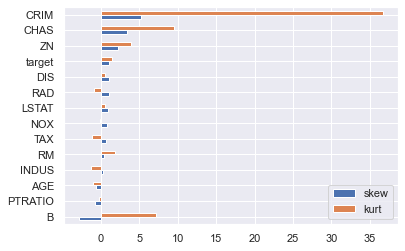

In [9]:
sk_df.sort_values(by='skew', ascending=True).plot(kind='barh')

In [10]:
X_train.columns

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT'],
      dtype='object')

# outlier

# scale

In [11]:
train = pd.concat([X_train, y_train], axis=1)
test  = pd.concat([X_test, y_test], axis=1)

scalers = [StandardScaler(), 
        #    MinMaxScaler(), 
        #    RobustScaler()
           ]

for col in train.columns:
    
    
    for scaler in scalers:
        
        reshape_train = np.array(train[col]).reshape(-1, 1)
        reshape_test  = np.array( test[col]).reshape(-1, 1)
        
        scaler.fit(reshape_train)
        sc_train = scaler.transform(reshape_train)
        sc_test  = scaler.transform(reshape_test)
        
        train[str(col) + scaler.__class__.__name__] = sc_train.reshape(-1, 1)
        test [str(col) + scaler.__class__.__name__] = sc_test.reshape(-1, 1)

In [12]:
train.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,...,NOXStandardScaler,RMStandardScaler,AGEStandardScaler,DISStandardScaler,RADStandardScaler,TAXStandardScaler,PTRATIOStandardScaler,BStandardScaler,LSTATStandardScaler,targetStandardScaler
220,0.35809,0.0,6.20,1.0,0.507,6.951,88.5,2.8617,8.0,307.0,...,-0.424879,0.935678,0.693669,-0.437218,-0.162242,-0.561656,-0.484638,0.371691,-0.411000,0.443044
71,0.15876,0.0,10.81,0.0,0.413,5.961,17.5,5.2873,4.0,305.0,...,-1.241859,-0.491181,-1.835528,0.730055,-0.624648,-0.573376,0.336491,0.205012,-0.387681,-0.098824
240,0.11329,30.0,4.93,0.0,0.428,6.897,54.3,6.3361,6.0,300.0,...,-1.111490,0.857849,-0.524621,1.234769,-0.393445,-0.602677,-0.849584,0.366609,-0.181919,-0.066312
6,0.08829,12.5,7.87,0.0,0.524,6.012,66.6,5.5605,5.0,311.0,...,-0.277127,-0.417676,-0.086464,0.861527,-0.509046,-0.538216,-1.488240,0.415732,-0.037886,0.031224
417,25.94060,0.0,18.10,0.0,0.679,5.304,89.1,1.6475,24.0,666.0,...,1.070021,-1.438097,0.715042,-1.021528,1.687378,1.542121,0.792674,-2.613393,1.911362,-1.323446


In [13]:
test.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,...,NOXStandardScaler,RMStandardScaler,AGEStandardScaler,DISStandardScaler,RADStandardScaler,TAXStandardScaler,PTRATIOStandardScaler,BStandardScaler,LSTATStandardScaler,targetStandardScaler
329,0.06724,0.0,3.24,0.0,0.460,6.333,17.2,5.2146,4.0,430.0,...,-0.833369,0.044972,-1.846215,0.695069,-0.624648,0.159137,-0.712729,0.185476,-0.736103,-0.001288
371,9.23230,0.0,18.10,0.0,0.631,6.216,100.0,1.1691,24.0,666.0,...,0.652840,-0.123657,1.103327,-1.251749,1.687378,1.542121,0.792674,0.083165,-0.435692,2.968150
219,0.11425,0.0,13.89,1.0,0.550,6.373,92.4,3.3633,5.0,276.0,...,-0.051154,0.102623,0.832597,-0.195833,-0.509046,-0.743319,-0.940821,0.394727,-0.302632,0.042062
403,24.80170,0.0,18.10,0.0,0.693,5.349,96.0,1.7028,24.0,666.0,...,1.191699,-1.373240,0.960837,-0.994916,1.687378,1.542121,0.792674,0.430412,0.968974,-1.551031
78,0.05646,0.0,12.83,0.0,0.437,6.232,53.7,5.0141,5.0,398.0,...,-1.033268,-0.100597,-0.545994,0.598583,-0.509046,-0.028387,0.108400,0.311840,-0.050232,-0.153011


In [14]:
train.columns

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'target', 'CRIMStandardScaler',
       'ZNStandardScaler', 'INDUSStandardScaler', 'CHASStandardScaler',
       'NOXStandardScaler', 'RMStandardScaler', 'AGEStandardScaler',
       'DISStandardScaler', 'RADStandardScaler', 'TAXStandardScaler',
       'PTRATIOStandardScaler', 'BStandardScaler', 'LSTATStandardScaler',
       'targetStandardScaler'],
      dtype='object')

In [15]:
# sk_df['MinMax_skew'] =     skew(train.iloc[:, 14::3])
# sk_df['MinMax_kurt'] = kurtosis(train.iloc[:, 14::3])

# sk_df['Standard_skew'] =     skew(train.iloc[:, 15::3])
# sk_df['Standard_kurt'] = kurtosis(train.iloc[:, 15::3])

# sk_df['Robust_skew'] =     skew(train.iloc[:, 16::3])
# sk_df['Robust_kurt'] = kurtosis(train.iloc[:, 16::3])

# sk_df

In [16]:
train.columns[14::3]

Index(['CRIMStandardScaler', 'CHASStandardScaler', 'AGEStandardScaler',
       'TAXStandardScaler', 'LSTATStandardScaler'],
      dtype='object')

<AxesSubplot:>

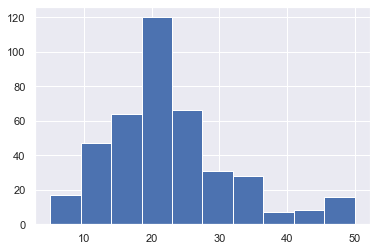

In [17]:
y_train.hist()

(404, 1)

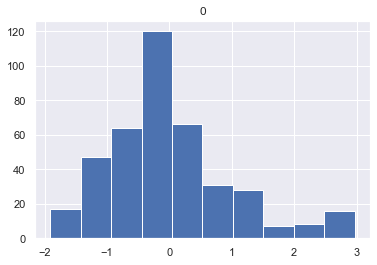

In [18]:
scale = StandardScaler()

y_train_reshape = np.array(y_train).reshape(-1, 1)

scale.fit(y_train_reshape)
sc_y_train = scale.transform(y_train_reshape)
# scale.transfrom(y_test)

pd.DataFrame(sc_y_train).hist()

sc_y_train.shape

In [19]:
sc_y_train.shape[0]

404

In [20]:
sc_y_train[0]

array([0.44304435])

<AxesSubplot:>

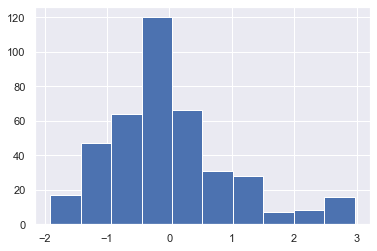

In [21]:
list = []
for i in range(sc_train.shape[0]):
    list.append(float(sc_y_train[i]))

pd.Series(list).hist()

In [22]:
sc_y_train.shape

(404, 1)

In [23]:
t = sc_y_train.reshape(-1)

In [24]:
print(t)

[ 4.43044345e-01 -9.88238901e-02 -6.63117960e-02  3.12244864e-02
 -1.32344610e+00 -7.71491607e-02 -2.18034902e-01  4.10532251e-01
  2.02529959e+00 -5.86505302e-01  4.86393804e-01 -2.39709631e-01
 -6.62366855e-01  1.93784957e-01 -1.54019340e+00  4.20618512e-02
 -1.39930766e+00  2.96815032e+00  8.54864204e-01 -1.11753617e+00
 -3.48083278e-01 -1.53010714e-01 -2.50546996e-01 -4.13107467e-01
  1.16914778e+00 -4.45619561e-01 -3.26408549e-01  1.14747305e+00
 -1.03083726e+00 -1.63772968e+00 -9.76650432e-01 -5.64830573e-01
 -1.54019340e+00  1.38589508e+00  1.50435498e-01 -9.98325161e-01
  3.88857522e-01 -1.67024177e+00 -1.03083726e+00  2.04622322e-01
  1.58096764e+00  2.58809145e-01  1.61272863e-01 -6.51529490e-01
  1.11496096e+00  1.47259399e+00 -1.25842191e+00 -1.67024177e+00
  2.03871217e-02  6.59791640e-01 -8.89951514e-01  1.93784957e-01
 -4.88969020e-01 -1.21249724e-02 -2.28872267e-01 -8.03252596e-01
 -5.64830573e-01 -9.76650432e-01 -1.50768130e+00 -4.78131655e-01
  1.38589508e+00  9.84912

In [25]:
t.shape

(404,)

In [26]:
scalers = [StandardScaler()]

for sc in scalers:
    
    sc.fit(np.array(y_train).reshape(-1, 1))
    y_train_mat = sc.transform(np.array(y_train).reshape(-1, 1))
    y_test_mat  = sc.transform(np.array(y_test).reshape(-1, 1))
    
    y_train_scale = pd.Series(y_train_mat.reshape(-1))
    y_test_scale  = pd.Series(y_test_mat.reshape(-1))

In [27]:
y_train_scale.shape, y_test_scale.shape

((404,), (102,))

## X scale met

In [28]:
# INPUT
X_train = train.drop(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'target', 'targetStandardScaler'], axis=1)
y_train = train['target']
X_test  = test.drop(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'target', 'targetStandardScaler'], axis=1)
y_test  = test['target']

models = [LinearRegression(), Ridge(), Lasso(), ElasticNet(), 
          DecisionTreeRegressor(), XGBRegressor(), LGBMRegressor()]

for model in models:
    print(model.__class__.__name__)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse  = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    
    print('MES  =', mse)
    print('RMSE = ', rmse)
    print('-' * 30)

LinearRegression
MES  = 33.448979997676496
RMSE =  5.783509315085133
------------------------------
Ridge
MES  = 33.5371130739407
RMSE =  5.791123645195352
------------------------------
Lasso
MES  = 40.14696456446331
RMSE =  6.336163236885813
------------------------------
ElasticNet
MES  = 42.87871149007003
RMSE =  6.548183831419979
------------------------------
DecisionTreeRegressor
MES  = 35.21705882352941
RMSE =  5.934396247600038
------------------------------
XGBRegressor
MES  = 21.36472443696006
RMSE =  4.622199091012854
------------------------------
LGBMRegressor
MES  = 24.5098863728449
RMSE =  4.950746042047087
------------------------------


## y scale met

In [29]:
# INPUT
X_train = train.drop(['target', 'CRIMStandardScaler',
       'ZNStandardScaler', 'INDUSStandardScaler', 'CHASStandardScaler',
       'NOXStandardScaler', 'RMStandardScaler', 'AGEStandardScaler',
       'DISStandardScaler', 'RADStandardScaler', 'TAXStandardScaler',
       'PTRATIOStandardScaler', 'BStandardScaler', 'LSTATStandardScaler',
       'targetStandardScaler'], axis=1)
y_train = train['targetStandardScaler']
X_test  = test.drop(['target', 'CRIMStandardScaler',
       'ZNStandardScaler', 'INDUSStandardScaler', 'CHASStandardScaler',
       'NOXStandardScaler', 'RMStandardScaler', 'AGEStandardScaler',
       'DISStandardScaler', 'RADStandardScaler', 'TAXStandardScaler',
       'PTRATIOStandardScaler', 'BStandardScaler', 'LSTATStandardScaler',
       'targetStandardScaler'], axis=1)
y_test  = test['targetStandardScaler']

models = [LinearRegression(), Ridge(), Lasso(), ElasticNet(), 
          DecisionTreeRegressor(), XGBRegressor(), LGBMRegressor()]

for model in models:
    print(model.__class__.__name__)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse  = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    
    print('MES  =', mse)
    print('RMSE = ', rmse)
    print('-' * 30)

LinearRegression
MES  = 0.39285316532882075
RMSE =  0.6267799975500341
------------------------------
Ridge
MES  = 0.4020449895864931
RMSE =  0.6340701771779628
------------------------------
Lasso
MES  = 0.6331890161021715
RMSE =  0.7957317488338463
------------------------------
ElasticNet
MES  = 0.5902948189250011
RMSE =  0.7683064615926389
------------------------------
DecisionTreeRegressor
MES  = 0.40565090837368123
RMSE =  0.6369072996705888
------------------------------
XGBRegressor
MES  = 0.24287479426238562
RMSE =  0.4928232890827965
------------------------------
LGBMRegressor
MES  = 0.2877334540613725
RMSE =  0.5364079175975803
------------------------------


## X, y scale met

In [30]:
# INPUT

X_train = train.drop(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'target', 'targetStandardScaler'], axis=1)
y_train = train['targetStandardScaler']
X_test  = test.drop(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'target', 'targetStandardScaler'], axis=1)
y_test  = test['targetStandardScaler']

models = [LinearRegression(), Ridge(), Lasso(), ElasticNet(), 
          DecisionTreeRegressor(), XGBRegressor(), LGBMRegressor()]

for model in models:
    print(model.__class__.__name__)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse  = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    
    print('MES  =', mse)
    print('RMSE = ', rmse)
    print('-' * 30)

LinearRegression
MES  = 0.3928531653288211
RMSE =  0.6267799975500343
------------------------------
Ridge
MES  = 0.3938882748593052
RMSE =  0.6276051902743517
------------------------------
Lasso
MES  = 0.9581718678127248
RMSE =  0.9788625377512027
------------------------------
ElasticNet
MES  = 0.7259495522082012
RMSE =  0.8520267320971808
------------------------------
DecisionTreeRegressor
MES  = 0.4158608654111256
RMSE =  0.6448727513324823
------------------------------
XGBRegressor
MES  = 0.2428194657384344
RMSE =  0.4927671516430802
------------------------------
LGBMRegressor
MES  = 0.2878648739017904
RMSE =  0.5365304035204252
------------------------------


## log scale

In [31]:
# log scale : (-) 없어야 함
y_train = train['target']
y_train.describe()

count    404.000000
mean      22.611881
std        9.238777
min        5.000000
25%       16.775000
50%       21.400000
75%       25.525000
max       50.000000
Name: target, dtype: float64

In [32]:
# 회귀분석은 가중치가 있어도, x에 따라서 y는 큰 차이가 남
# 회귀분석 필수 조건 : scale(정규화), log scale(큰 수치 drop), 규제 사용(overfitting 방지)
list = [1, 5, 10, 20, 30]
arr = np.array(list)
log_arr = np.log(arr)
log_arr

array([0.        , 1.60943791, 2.30258509, 2.99573227, 3.40119738])

<AxesSubplot:xlabel='target', ylabel='Count'>

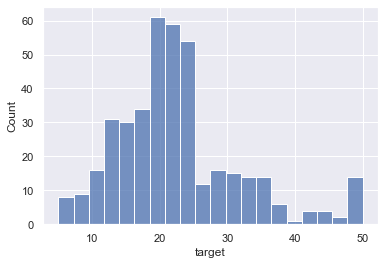

In [33]:
sns.histplot(y_train)

<AxesSubplot:xlabel='target', ylabel='Count'>

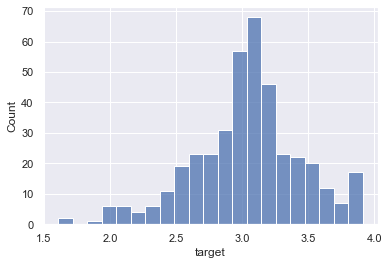

In [34]:
y_train_log = np.log(y_train)
sns.histplot(y_train_log)

## log scale & scale

In [38]:
X_train = train.drop(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'target', 'targetStandardScaler'], axis=1)
y_train = train['targetStandardScaler']
X_test  = test.drop(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'target', 'targetStandardScaler'], axis=1)
y_test  = test['targetStandardScaler']

# np.log1p : log + 1, underflow 방지
X_train_log = np.log(X_train)
X_test_log  = np.log(X_test)
y_train_log = np.log(y_train)
y_test_log  = np.log(y_test)

# INPUT
X_train = X_train_log
X_test  = X_test_log
y_train = y_train_log
y_test  = y_test_log

models = [LinearRegression(), Ridge(), Lasso(), ElasticNet(), 
          DecisionTreeRegressor(), XGBRegressor(), LGBMRegressor()]

for model in models:
    print(model.__class__.__name__)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse  = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    
    print('MES  =', mse)
    print('RMSE = ', rmse)
    print('-' * 30)

LinearRegression


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').